In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import datetime as dt
from math import factorial

metrics_path = '../metrics/'
figure_path = 'figures/'

def get_filenames_in_folder(path):
    file_names = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.lower().endswith('.csv')]
    file_names.sort()
    return file_names

all_files = get_filenames_in_folder(metrics_path)
print(all_files)

def read_file(path):
    return pd.read_csv(path, comment='#')

if len(all_files) > 0:
    latest_data = read_file(all_files[0])
    print(latest_data.iloc[1])

GLOBAL_STYLE = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'font.size': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.axisbelow': True  # grid lines below data
}

FIGURE_SIZE = (12, 7)

LINE_STYLE = {
    "linewidth": 1.5,
    "linestyle": "-"  # solid lines
}

GRID_STYLE = {
    "visible": True,
    "linestyle": "--",
    "alpha": 0.6
}

plt.rcParams.update(GLOBAL_STYLE)

['../metrics/2025-07-31_10-12-42_metrics.csv']
timestamp    2025-07-31T10:08:36+00:00
field                   fragments_sent
value                              0.0
node                            node_0
Name: 1, dtype: object


[0.003   0.00475 0.0065  0.00825 0.01   ]
[41.02993774 32.00982809 27.97885021 25.58615414 24.06298621]
[0.42050925 0.26617291 0.19375441 0.15176312 0.12437095]
5
[np.float64(97.57202219963074), np.float64(120.25952553749084), np.float64(144.4036796092987), np.float64(168.5927028656006), np.float64(193.47755241394043)]


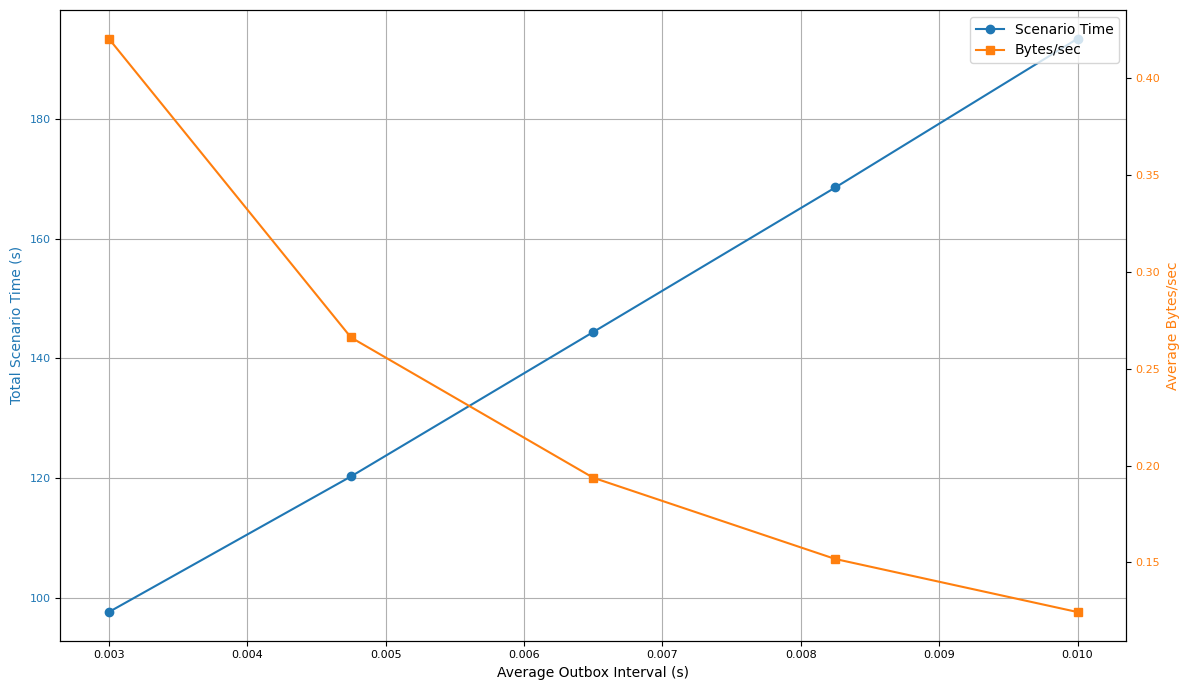

In [3]:
# Time per scenario
# 10 rounds
# y: time per whole scenario
# x: delay in seconds

mus = np.linspace(0.003, 0.01, num=5)
print(mus)

rt_files = get_filenames_in_folder(join(metrics_path, "run_time"))

def deserizalize_time(str_time):
    return dt.datetime.fromisoformat(str_time)

def get_duration(df):
    filtered_df = df.loc[df['field'] == "round_time"]
    return filtered_df['value'].max()

def get_total_msgbytes(df):
    return df[df['field'] == "total_mbytes_sent"].groupby('node')['value'].max().mean()

df_rt_files = [read_file(f) for f in rt_files]
rt_list = [get_duration(df) for df in df_rt_files]
bytes_list = np.array([get_total_msgbytes(df) for df in df_rt_files])
print(bytes_list)
bytes_s = bytes_list / rt_list
print(bytes_s)
print(len(rt_list))
print(rt_list)

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

# First y-axis: Scenario time
ax1.plot(mus[:len(rt_list)], rt_list, marker='o', color='tab:blue', label='Scenario Time')
ax1.set_xlabel('Average Outbox Interval (s)')
ax1.set_ylabel('Total Scenario Time (s)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Second y-axis: Bytes per second
ax2 = ax1.twinx()
ax2.plot(mus[:len(bytes_s)], bytes_s, marker='s', color='tab:orange', label='Bytes/sec')
ax2.set_ylabel('Average Bytes/sec', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add grid only on primary axis
ax1.grid(True)
fig.tight_layout()

# Optional: Add a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Save and show
plt.savefig(join(figure_path, "time-and-bytes-per-scenario.png"))
plt.show()


In [4]:
# CPU utilization per state (training, waiting, aggregating, broadcasting)
# y: Total CPU time per stage
# x:
#   - number of nodes       
#   - number of hops        

nr_nodes    = [2, 4, 6, 8, 10, 12]
nr_hops     = [1, 2, 3, 4]
outbox_size = [10 + (i) * 30 for i in range(6)]
print(outbox_size)

stages = {1: "Training", 3: "Broadcasting and Receiving"}

def stage_plot(property, title, folder):
    cpu_files = get_filenames_in_folder(join(metrics_path, folder))
    df_cpu_files = [read_file(f) for f in cpu_files]

    def get_cpu_per_stage(df):
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

        stage_df = df[df['field'] == 'stage'].copy()
        stage_df = stage_df.sort_values('timestamp')
        stage_df = (
            df[df['field'] == 'stage']
            .sort_values('timestamp')
            .groupby(['value', 'node'], as_index=False)
            .last()
        )
        stage_df = stage_df[stage_df['value'].isin(stages.keys())]

        cpu_df = df[df['field'] == 'cpu_total_ns'].copy()
        cpu_df = cpu_df.sort_values('timestamp')

        results = []

        for _, stage_row in stage_df.iterrows():
            stage_time = stage_row['timestamp']
            stage_num = int(stage_row['value'])
            node = stage_row['node']

            cpu_before_stage = cpu_df[(cpu_df['node'] == node) & (cpu_df['timestamp'] <= stage_time)]

            if not cpu_before_stage.empty:
                latest_cpu = cpu_before_stage.iloc[-1]  # last (latest) row
                results.append({
                    'node': node,
                    'stage': stage_num,
                    'cpu_total_ns': float(latest_cpu['value']),
                    'timestamp': latest_cpu['timestamp']
                })

        cpu_per_stage_df = pd.DataFrame(results)

        cpu_per_stage_df = cpu_per_stage_df.sort_values(['node', 'stage'])

        cpu_per_stage_df['cpu_per_stage'] = cpu_per_stage_df.groupby('node')['cpu_total_ns'].diff().fillna(cpu_per_stage_df['cpu_total_ns'])

        return cpu_per_stage_df


    cpu_values_per_batch = []

    for df in df_cpu_files:
        stage_df = get_cpu_per_stage(df)

        stage_totals = stage_df.groupby('stage')['cpu_per_stage'].mean()

        cpu_row = [stage_totals.get(stage, 0) for stage in stages.keys()]
        cpu_values_per_batch.append(cpu_row)
        
    property = property[:len(cpu_values_per_batch)]
    cpu_values_per_batch = cpu_values_per_batch[:len(property)]

    data = np.array(cpu_values_per_batch)

    x = np.arange(len(property))
    width = 0.2

    plt.figure(figsize=FIGURE_SIZE)

    for i, stage in enumerate(stages):
        plt.bar(x + i * width, data[:, i], width=width, label=stages[stage])

    plt.xticks(x + width, property)
    plt.xlabel(title)
    plt.ylabel('CPU Ns')
    plt.title('CPU Usage per Stage, ' + title)
    plt.legend(title='Stage')
    plt.savefig(join(figure_path, f"cpu_per_stage_{folder}.png"))
    plt.tight_layout()

    plt.grid(**GRID_STYLE)

    plt.show()

[10, 40, 70, 100, 130, 160]


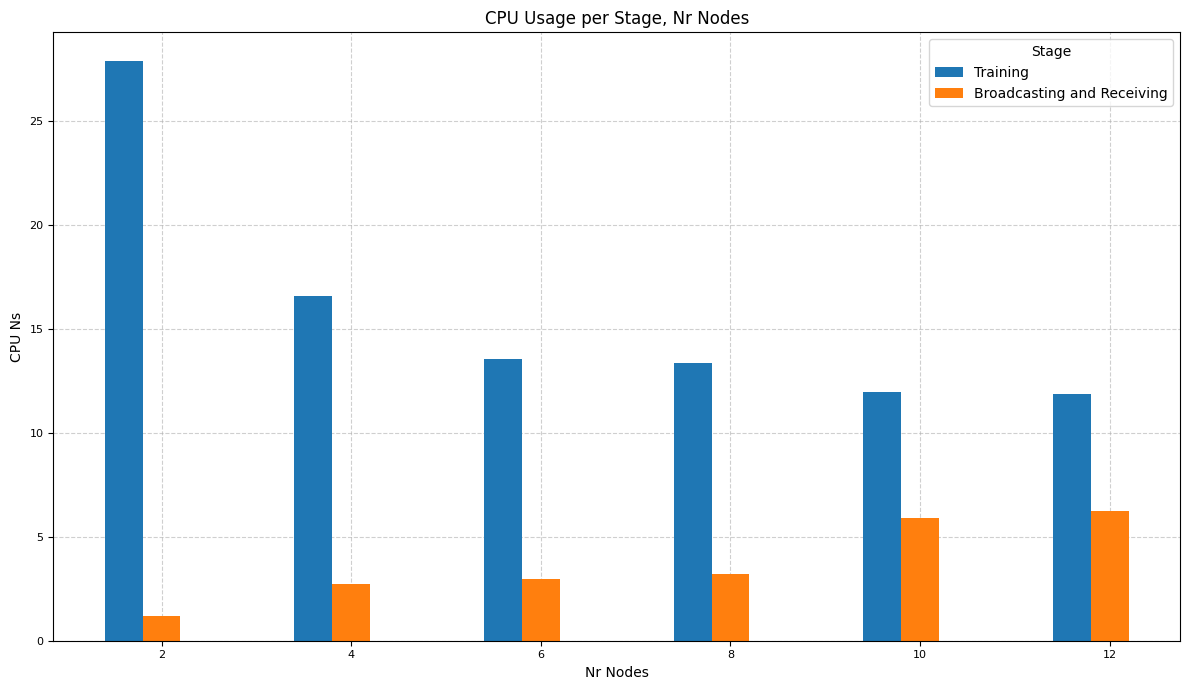

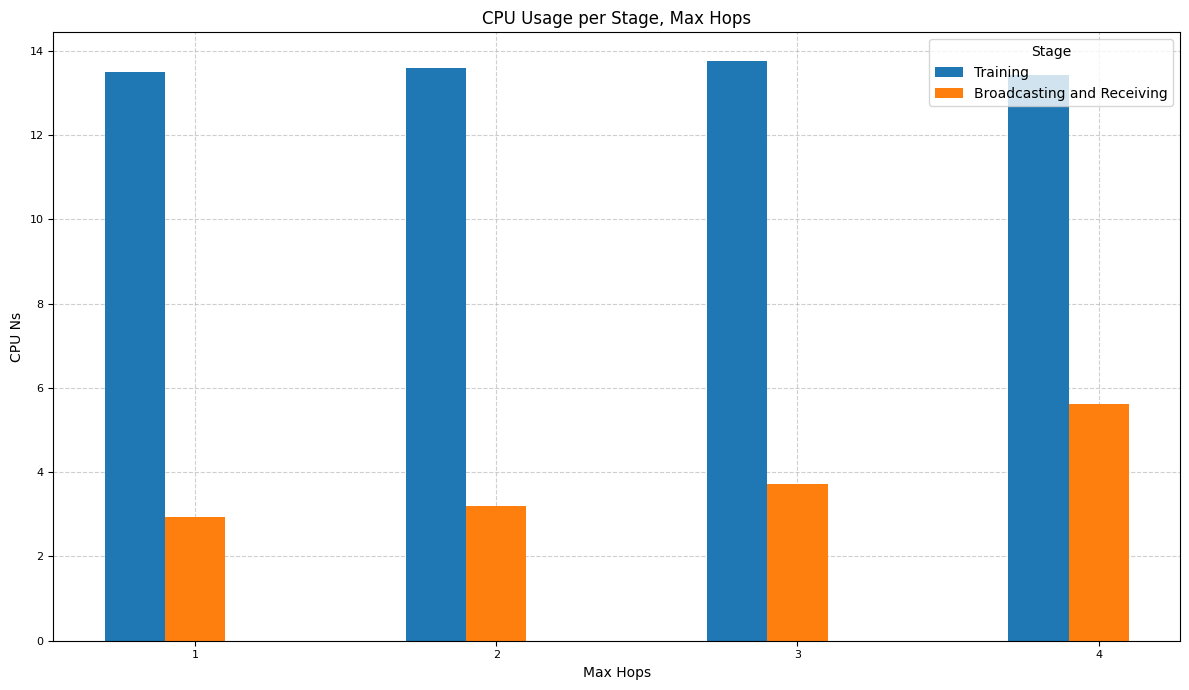

In [5]:
stage_plot(nr_nodes, "Nr Nodes", "nr_nodes")
stage_plot(nr_hops, "Max Hops", "max_hops")

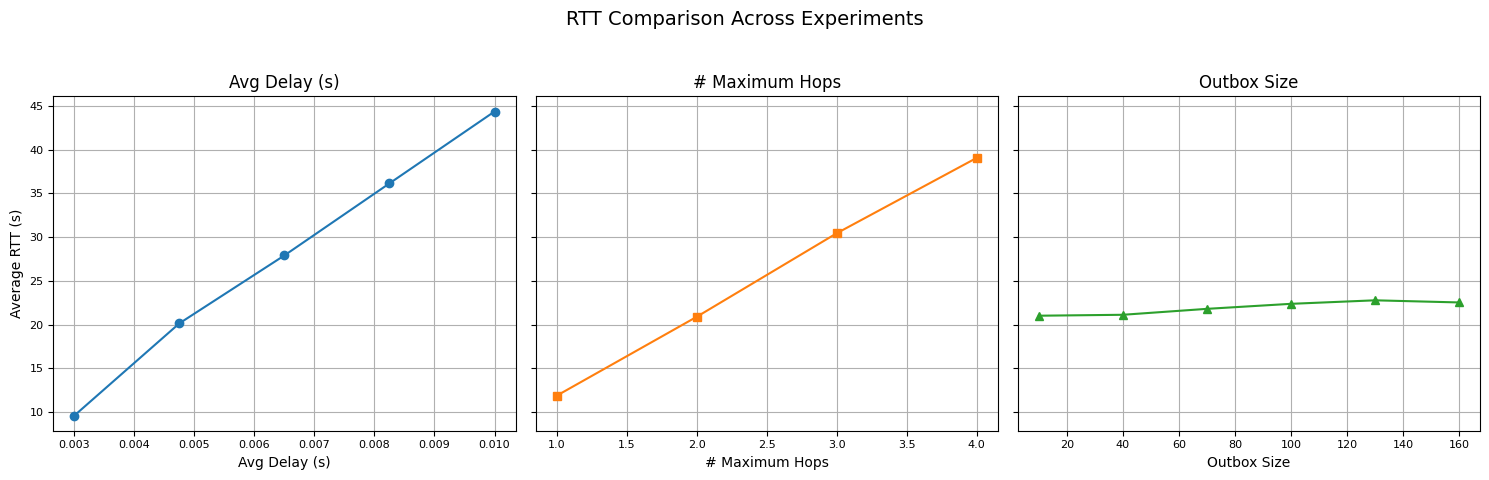

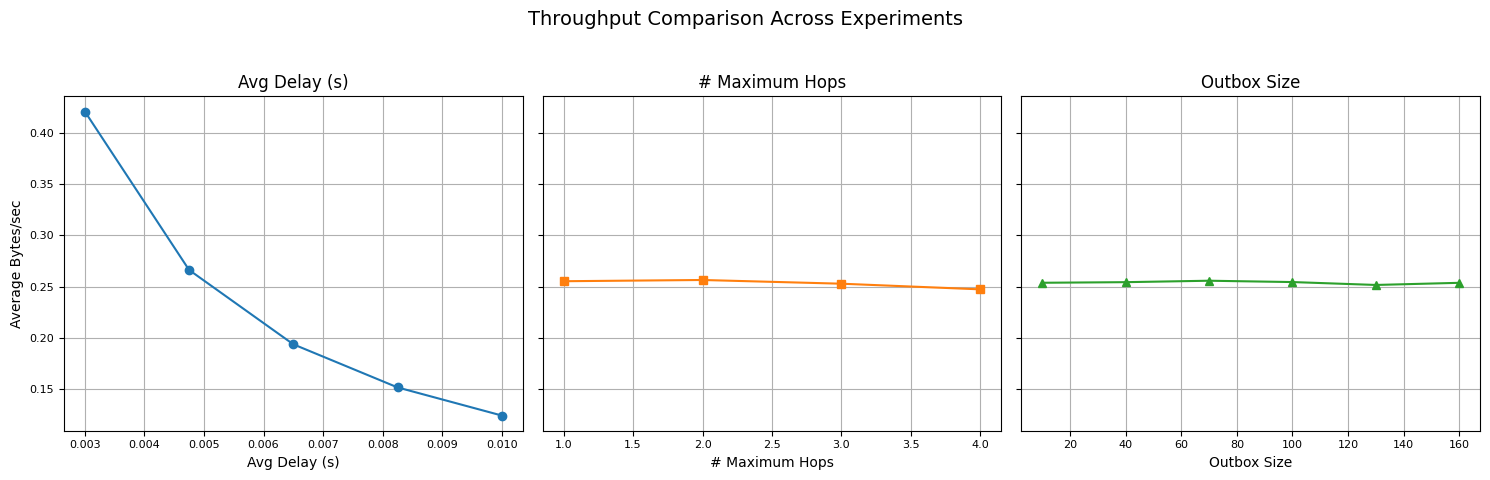

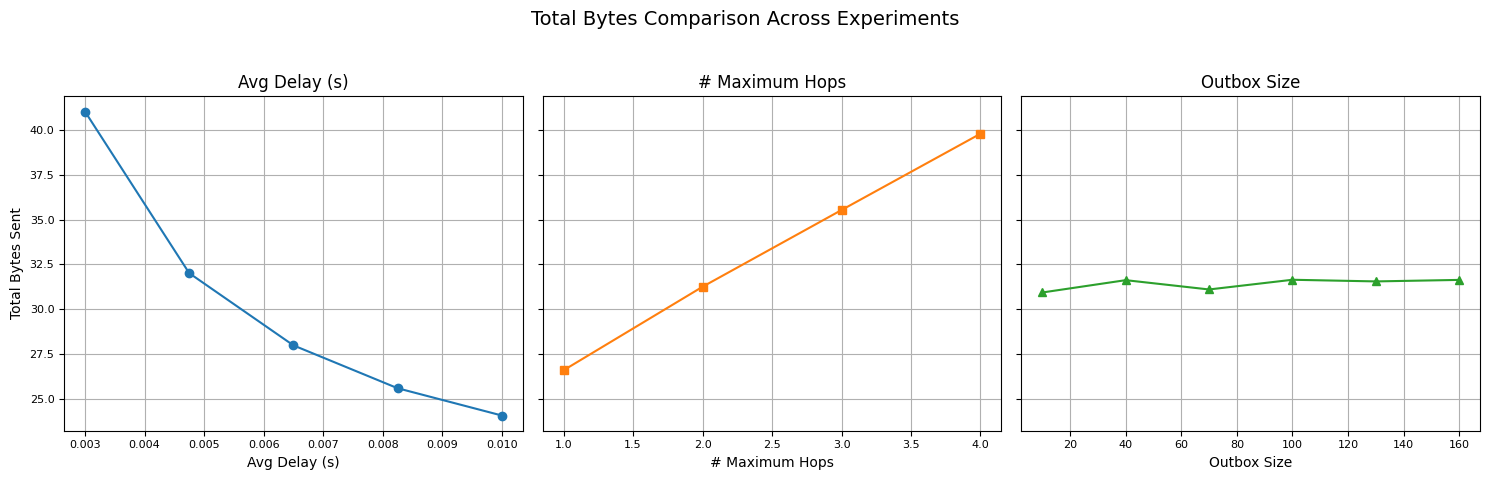

In [6]:
# y: RTT
# x:
#   - delay in seconds
#   - number of hops


def get_avg_rtt(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    # max_peers = df[df['field'] == "active_peers"]["value"].max()
    # start, end = get_time_interval(df, "active_peers", max_peers)

    # df_interval = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    # df_interval = df
    rtt_per_node = df[(df['field'] == "last_rtt") & (df['value'] != 0)].groupby('node')
    mean_per_node = rtt_per_node['value'].apply(lambda x: x.unique().mean())
    mean = mean_per_node.mean()
    return mean

def plot_combined_rtt_and_bytes_subplots(x_sets, x_labels, folders, image_prefix):
    # Create 1 row with 3 columns for RTT
    fig_rtt, axs_rtt = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig_bytes, axs_bytes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig_total_bytes, axs_total_bytes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    markers = ['o', 's', '^']
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    for i, (x_vals, xlabel, folder) in enumerate(zip(x_sets, x_labels, folders)):
        files = get_filenames_in_folder(join(metrics_path, folder))
        df_files = [read_file(f) for f in files]

        y_rtt = [get_avg_rtt(df) for df in df_files]
        rt_list = [get_duration(df) for df in df_files]
        y_total_bytes = np.array([get_total_msgbytes(df) for df in df_files])
        y_bytes_s = y_total_bytes / rt_list

        # Ensure all y values match x_vals in length
        n = min(len(df_files), len(x_vals))
        x_vals = x_vals[:n]
        y_rtt = y_rtt[:n]
        y_bytes_s = y_bytes_s[:n]
        y_total_bytes = y_total_bytes[:n]

        # RTT subplot
        axs_rtt[i].plot(x_vals, y_rtt, marker=markers[i], color=colors[i])
        axs_rtt[i].set_title(xlabel)
        axs_rtt[i].set_xlabel(xlabel)
        if i == 0:
            axs_rtt[i].set_ylabel("Average RTT (s)")
        axs_rtt[i].grid(True)

        # Bytes/sec subplot
        axs_bytes[i].plot(x_vals, y_bytes_s, marker=markers[i], color=colors[i])
        axs_bytes[i].set_title(xlabel)
        axs_bytes[i].set_xlabel(xlabel)
        if i == 0:
            axs_bytes[i].set_ylabel("Average Bytes/sec")
        axs_bytes[i].grid(True)

        # Total bytes subplot
        axs_total_bytes[i].plot(x_vals, y_total_bytes, marker=markers[i], color=colors[i])
        axs_total_bytes[i].set_title(xlabel)
        axs_total_bytes[i].set_xlabel(xlabel)
        if i == 0:
            axs_total_bytes[i].set_ylabel("Total Bytes Sent")
        axs_total_bytes[i].grid(True)

    # Adjust and save
    fig_rtt.suptitle("RTT Comparison Across Experiments", fontsize=14)
    fig_bytes.suptitle("Throughput Comparison Across Experiments", fontsize=14)
    fig_total_bytes.suptitle("Total Bytes Comparison Across Experiments", fontsize=14)
    fig_rtt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_bytes.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_total_bytes.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_rtt.savefig(join(figure_path, f"{image_prefix}_rtt_subplots.png"))
    fig_bytes.savefig(join(figure_path, f"{image_prefix}_bytes_subplots.png"))
    fig_total_bytes.savefig(join(figure_path, f"{image_prefix}_total_bytes_subplots.png"))
    plt.show()


x_sets = [mus, nr_hops, outbox_size]
x_labels = ["Avg Delay (s)", "# Maximum Hops", "Outbox Size"]
folders = ["run_time", "max_hops", "outbox_size"]

plot_combined_rtt_and_bytes_subplots(x_sets, x_labels, folders, "combined_metrics")

The output rate of a node is solely determined by the average output rate parameter, therefore the curve is completely flat for max hops and otubox size

Therefore, total bytes increase with maximum hops and it decreases all the same with avg outbox interval, bc it controls the amount of cover traffic.

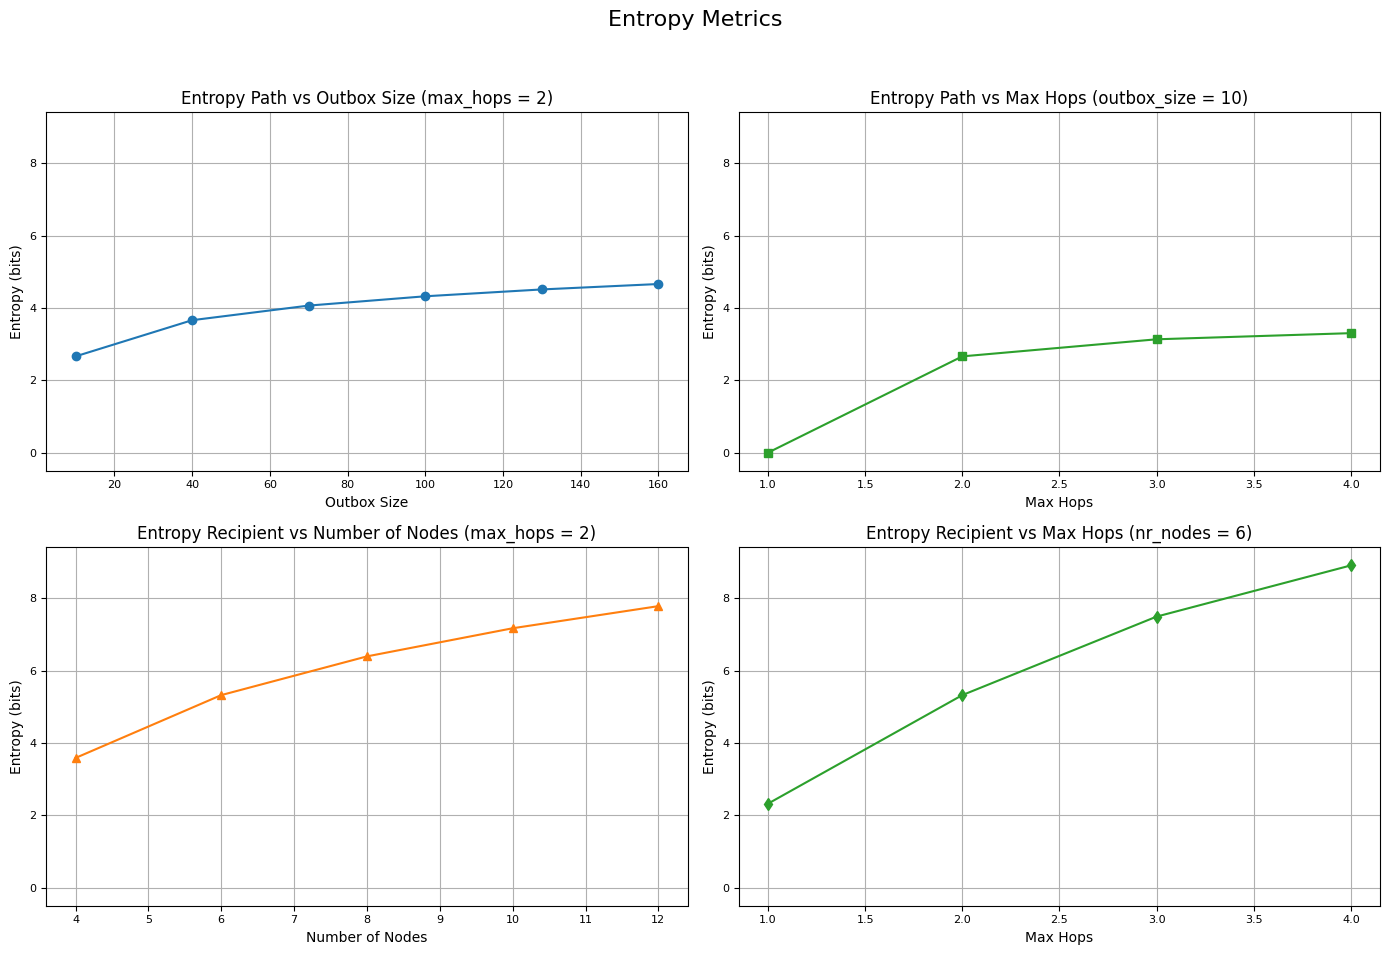

In [25]:
def entropy(probs):
    sum = 0
    for p in probs:
        sum += p * np.log2(p)
    return -sum

# the entropy of matching incoming message to outgoing message in a singular node
def entropy_in_out(outbox_size, max_hops):
    terminated = 1/max_hops
    relayed = 1 - terminated
    relayed_events = [relayed * 1/outbox_size] * outbox_size if relayed != 0 else []
    events = relayed_events + [terminated]
    return entropy(events)

#tracking a fragment across 3 nodes, start node, in between node, end node
# X = 1, fragment ends up at node 3, X = 0, fragment does not end up at end node
def entropy_path(max_hops, outbox_size):
    p_incoming_same_as_outgoing_in_2 = 1/outbox_size
    p_frag_terminates_at_3 = 1/max_hops
    p1 = p_incoming_same_as_outgoing_in_2 * p_frag_terminates_at_3
    p0 = 1 - p1
    return entropy([p0, p1])

# X e nodes - start node
# probability of tracking a fragment to its recipient
def entropy_recipient(max_hops, nr_nodes):
    n_events = 0
    for hops in range(1, max_hops+1):
        n_per_hops = int(factorial(nr_nodes-1)/factorial(nr_nodes-1-max_hops))
        n_events += n_per_hops
    probs = [1/n_events] * n_events
    return entropy(probs)

y_e_io_outbox   = [entropy_in_out(outbox, 2) for outbox in outbox_size]
y_e_io_hops     = [entropy_in_out(10, hops) for hops in nr_hops]
y_e_rec_hops    = [entropy_recipient(2, nodes) for nodes in nr_nodes[1:]]
y_e_rec_nodes   = [entropy_recipient(hops, 6) for hops in nr_hops]

all_vals = y_e_io_outbox + y_e_io_hops + y_e_rec_hops + y_e_rec_nodes
max_y = max(all_vals) + 0.5
min_y = min(all_vals) - 0.5

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()  # makes indexing easier (axs[0] to axs[3])

# Plot 1: entropy_path vs outbox_size (max_hops = 2)
axs[0].plot(outbox_size, y_e_io_outbox, marker='o', color='tab:blue')
axs[0].set_title("Entropy Path vs Outbox Size (max_hops = 2)")
axs[0].set_xlabel("Outbox Size")
axs[0].set_ylabel("Entropy (bits)")
axs[0].grid(True)
axs[0].set_ylim(min_y, max_y)

# Plot 2: entropy_path vs max_hops (outbox_size = 10)
axs[1].plot(nr_hops, y_e_io_hops, marker='s', color='tab:green')
axs[1].set_title("Entropy Path vs Max Hops (outbox_size = 10)")
axs[1].set_xlabel("Max Hops")
axs[1].set_ylabel("Entropy (bits)")
axs[1].grid(True)
axs[1].set_ylim(min_y, max_y)

# Plot 3: entropy_recipient vs nr_nodes (max_hops = 2)
axs[2].plot(nr_nodes[1:], y_e_rec_hops, marker='^', color='tab:orange')
axs[2].set_title("Entropy Recipient vs Number of Nodes (max_hops = 2)")
axs[2].set_xlabel("Number of Nodes")
axs[2].set_ylabel("Entropy (bits)")
axs[2].grid(True)
axs[2].set_ylim(min_y, max_y)

# Plot 4: entropy_recipient vs max_hops (nr_nodes = 6)
axs[3].plot(nr_hops, y_e_rec_nodes, marker='d', color='tab:green')
axs[3].set_title("Entropy Recipient vs Max Hops (nr_nodes = 6)")
axs[3].set_xlabel("Max Hops")
axs[3].set_ylabel("Entropy (bits)")
axs[3].grid(True)
axs[3].set_ylim(min_y, max_y)

# Adjust layout and save
fig.suptitle("Entropy Metrics", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(join(figure_path, "entropy_combined_subplots.png"))
plt.show()


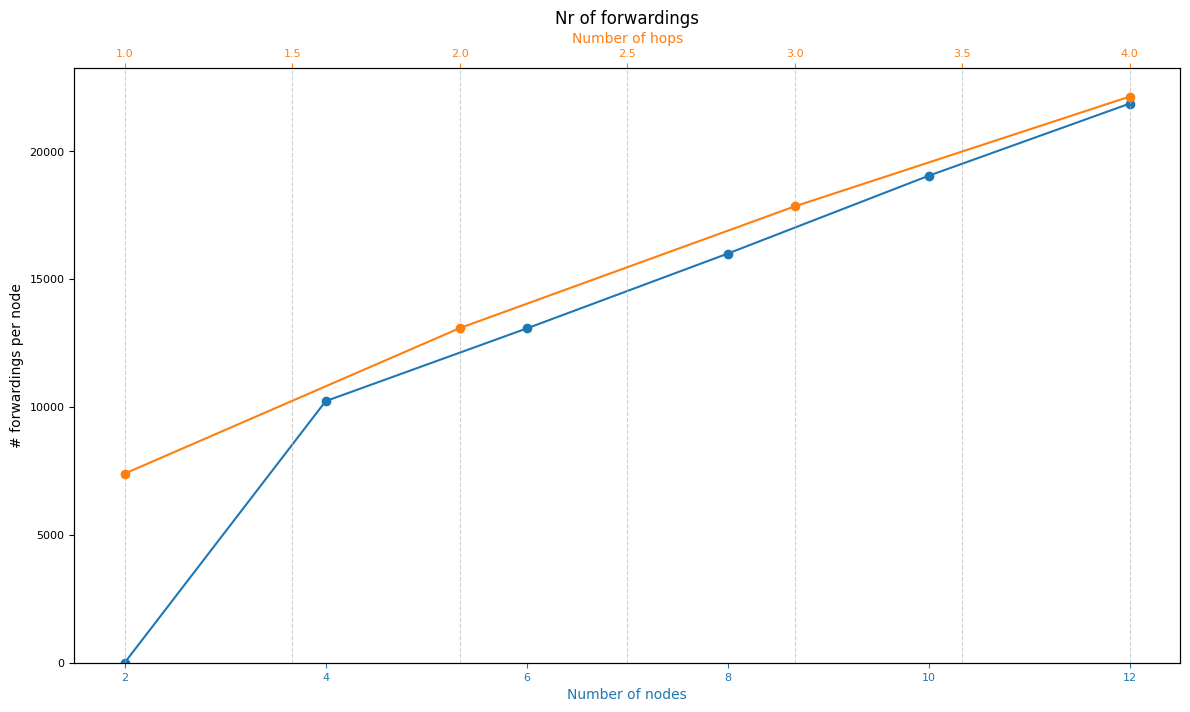

In [ ]:
def get_nr_forwardings(df):
    max_mean = df[df["field"] == "forwarded"].groupby("node")['value'].max().mean()
    return max_mean

def get_y_axis_values(folder):
    files = get_filenames_in_folder(join(metrics_path, folder))
    df_files = [read_file(f) for f in files]
    return [get_nr_forwardings(df) for df in df_files]

def plot_avg_forwardings(x_axis, y_axis, ax, xlabel, color):
    n = min(len(x_axis), len(y_axis))
    x_axis, y_axis = x_axis[:n], y_axis[:n]
    ax.plot(x_axis, y_axis, marker='o', color=color, label=xlabel)
    ax.set_xlabel(xlabel, color=color)
    ax.set_ylabel("# forwardings per node")
    ax.tick_params(axis='x', colors=color)

y_nodes = get_y_axis_values("nr_nodes")
y_hops = get_y_axis_values("max_hops")

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

plot_avg_forwardings(nr_nodes, y_nodes, ax1, "Number of nodes", color='tab:blue')
ax1.set_ylabel("# forwardings per node")
ax1.set_ylim(bottom=0, top=max(max(y_nodes), max(y_hops)) * 1.05)

ax2 = ax1.twiny()
plot_avg_forwardings(nr_hops[:4], y_hops, ax2, "Number of hops", color='tab:orange')

plt.tight_layout()
plt.title("Nr of forwardings")
plt.grid(True, axis='y')
plt.savefig(join(figure_path, "nr_forwardings.png"))
plt.grid(**GRID_STYLE)
plt.show()


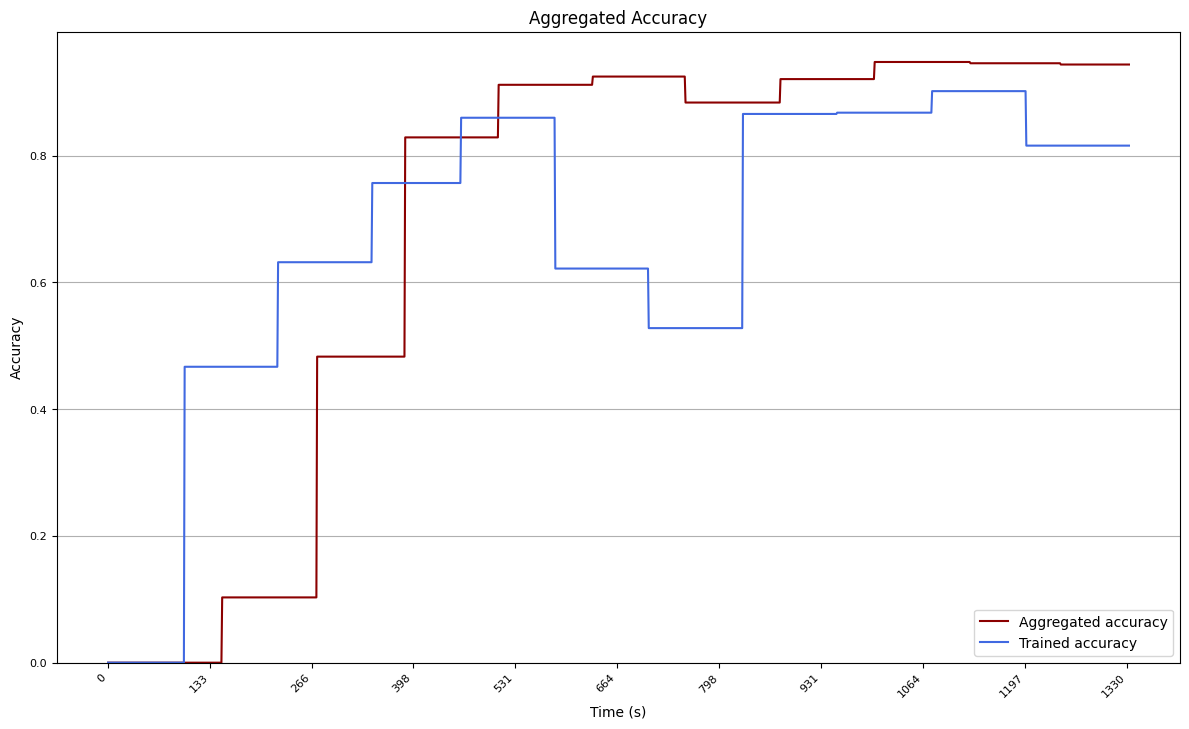

In [ ]:
def plot_acc(node):
    filename = get_filenames_in_folder(join(metrics_path, "accuracy"))[2]
    df = read_file(filename)

    timestamps = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['timestamp']
    timestamps = pd.to_datetime(timestamps)

    # Convert to seconds starting at 0
    x_axis = (timestamps - timestamps.min()).dt.total_seconds()

    agg_acc = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['value']
    acc = df[(df['node'] == node) & (df['field'] == 'accuracy')]['value']

    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    ax.plot(x_axis, agg_acc, color='darkred', label="Aggregated accuracy")
    ax.plot(x_axis, acc, color='royalblue', label="Trained accuracy")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(bottom=0, top=max(max(agg_acc), max(acc)) * 1.05)

    step = max(1, len(x_axis) // 10)
    ax.set_xticks(x_axis[::step])

    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.title("Aggregated Accuracy")
    plt.grid(True, axis='y')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.savefig(join(figure_path, "agg_accuracy.png"))
    plt.show()


plot_acc('node_0')
    


[0.9495     0.9075     0.80166667 0.819      0.7822     0.7585    ]


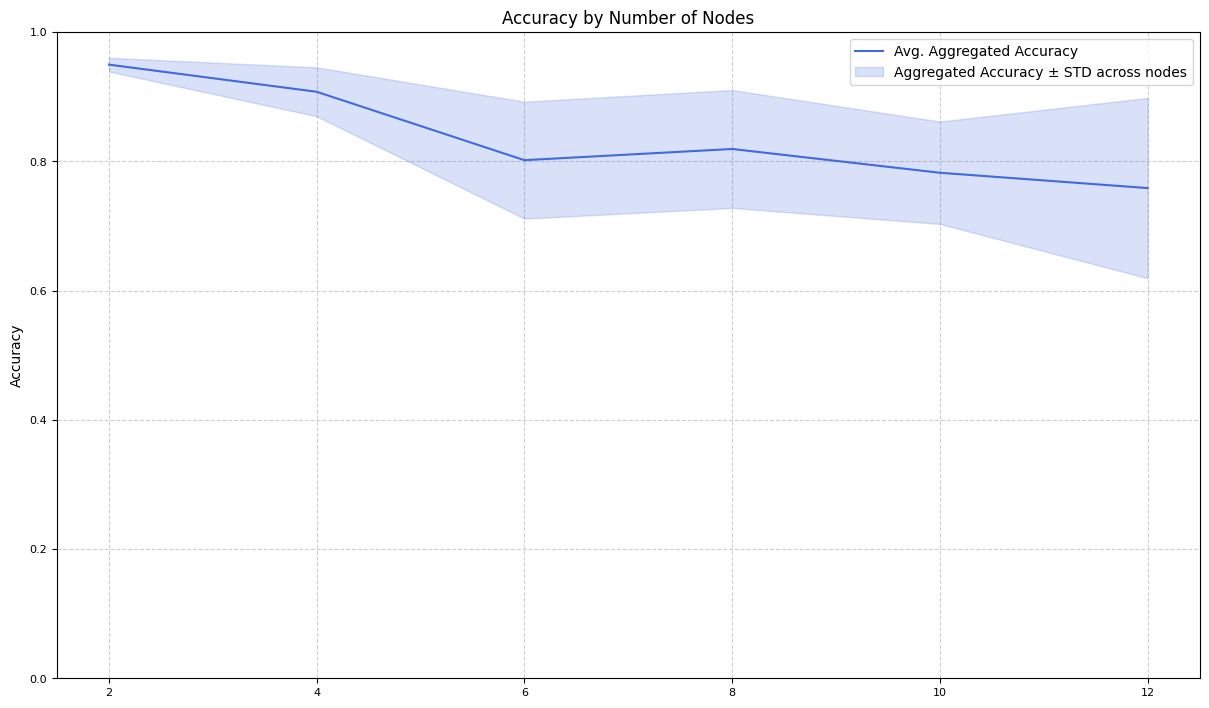

In [ ]:
plt.figure(figsize=FIGURE_SIZE)

files = get_filenames_in_folder(join(metrics_path, "accuracy"))
dfs = [read_file(f) for f in files]

def get_attr_per_node(df, attr):
    return df[df['field'] == attr].groupby('node').tail(1)['value']

local_mean = np.array([get_attr_per_node(df, 'accuracy').mean() for df in dfs])
local_std = np.array([get_attr_per_node(df, 'accuracy').std() for df in dfs])

print(local_mean)

plt.plot(nr_nodes, local_mean, color="royalblue", label="Avg. Aggregated Accuracy")
plt.fill_between(
    nr_nodes,
    local_mean - local_std,
    local_mean + local_std,
    color="royalblue",
    alpha=0.2,
    label="Aggregated Accuracy ± STD across nodes"
)

plt.ylim(0, 1)
plt.tight_layout()
plt.ylabel("Accuracy")
plt.title("Accuracy by Number of Nodes")
plt.legend()
plt.grid(**GRID_STYLE)
plt.savefig(join(figure_path, "accuracy_by_nodes.png"))
plt.show()